In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28*28, 500, False)  # 28*28 from image dimension 
        self.fc2 = nn.Linear(500, 300,False)
        self.fc3 = nn.Linear(300, 5,False)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
if torch.cuda.is_available():
  net = net.cuda()

tmpNet = net
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=False)
  (fc2): Linear(in_features=500, out_features=300, bias=False)
  (fc3): Linear(in_features=300, out_features=5, bias=False)
)


In [3]:
from torchvision import datasets
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
np.random.seed(0)


def data_loader(batch_size=2048, n_workers=2):

    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    #test_data_th = datasets.MNIST(root='./datasets', download=True, train=False)

    label = [1, 2, 3 ,4, 6]
    data_fea = np.array(train_data_th.data[:]).reshape([-1, 28 * 28]).astype(np.float32)
    data_fea = (data_fea / 255)
    data_gnd = np.array(train_data_th.targets)
    ctr1_idx = np.where(data_gnd[:] == label[0])
    ctr2_idx = np.where(data_gnd[:] == label[1])
    ctr3_idx = np.where(data_gnd[:] == label[2])
    ctr4_idx = np.where(data_gnd[:] == label[3])
    ctr6_idx = np.where(data_gnd[:] == label[4])
    ctr1_idx = np.array(ctr1_idx)
    ctr1_idx = ctr1_idx[0,0:1500]
    ctr2_idx = np.array(ctr2_idx)
    ctr2_idx = ctr2_idx[0,0:1500]
    ctr3_idx = np.array(ctr3_idx)
    ctr3_idx = ctr3_idx[0,0:1500]
    ctr4_idx = np.array(ctr4_idx)
    ctr4_idx = ctr4_idx[0,0:1500]
    ctr6_idx = np.array(ctr6_idx)
    ctr6_idx = ctr6_idx[0,0:1500]
    train_idx = np.concatenate((ctr1_idx[:500], ctr2_idx[:500], ctr3_idx[:500], ctr4_idx[:500], ctr6_idx[:500]),axis = None)
    validation_idx = np.concatenate((ctr1_idx[500:1000], ctr2_idx[500:1000], ctr3_idx[500:1000], ctr4_idx[500:1000], ctr6_idx[500:1000]),axis = None)
    test_idx = np.concatenate((ctr1_idx[1000:1500], ctr2_idx[1000:1500], ctr3_idx[1000:1500], ctr4_idx[1000:1500], ctr6_idx[1000:1500]),axis = None)

    data_train = data_fea[train_idx]
    target_train = data_gnd[train_idx]

    data_validation = data_fea[validation_idx]
    target_validation = data_gnd[validation_idx]

    data_test = data_fea[test_idx]
    target_test = data_gnd[test_idx]

    ##not sure what this is doing but it was here in the og
    dtrain_mean = data_train.mean(axis=0)
    data_train -= dtrain_mean
    data_validation -=dtrain_mean
    data_test -= dtrain_mean
    ##

    #######
    #https://discuss.pytorch.org/t/indexerror-target-2-is-out-of-bounds/69614/24 I AM SO HAPPY I FOUND THIS FORUM!
    tensor_target_train = torch.from_numpy(target_train)
    # print(tensor_target_train.size())
    # print(min(tensor_target_train))
    # print(max(tensor_target_train))
    unique_targets_train = torch.unique(tensor_target_train)
    # print('unique_targets_train: {}'.format(unique_targets_train))

    new_tensor_target_train = torch.empty_like(tensor_target_train)
    for idx, t in enumerate(unique_targets_train):
        # print('replacing {} with {}'.format(t, idx))
        new_tensor_target_train[tensor_target_train == t] = idx
    # print(new_tensor_target_train.size())
    # print(min(new_tensor_target_train))
    # print(max(new_tensor_target_train))

    tensor_target_validation = torch.from_numpy(target_validation)
    unique_targets_validation = torch.unique(tensor_target_validation)
    new_tensor_target_validation = torch.empty_like(tensor_target_validation)
    for idx, t in enumerate(unique_targets_validation):
      new_tensor_target_validation[tensor_target_validation == t] = idx

    tensor_target_test = torch.from_numpy(target_test)
    unique_targets_test = torch.unique(tensor_target_test)
    new_tensor_target_test = torch.empty_like(tensor_target_test)
    for idx, t in enumerate(unique_targets_test):
      new_tensor_target_test[tensor_target_test == t] = idx


    train_data = TensorDataset(torch.from_numpy(data_train), new_tensor_target_train)
    validation_data = TensorDataset(torch.from_numpy(data_validation), new_tensor_target_validation)
    test_data = TensorDataset(torch.from_numpy(data_test), new_tensor_target_test)

    train_loader = DataLoader(train_data, num_workers=n_workers, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, num_workers = n_workers, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_data, num_workers=n_workers, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader

In [4]:
def calc_acc(loader, net):
    correct_cnt = 0
    total_cnt = 0
    for batch_inputs, batch_labels in loader:
        if torch.cuda.is_available():
            batch_inputs = batch_inputs.cuda()
            batch_labels = batch_labels.cuda()
        total_cnt += len(batch_inputs)
        out = net(batch_inputs[:])
        _, pred_labels = torch.max(out.data, 1)
        correct_cnt += (pred_labels == batch_labels).sum().item()

    return correct_cnt / total_cnt


In [5]:
plotlr = []
plotval = []
plottrain = []
plotepoch = []
plotloss = []

In [6]:
nnloss = torch.nn.CrossEntropyLoss()
from torch import nn, optim

def train_net(net, i):
    # Your task is to choose best parameters of optimization (momentum, batch size, learning rate, l2 regularization).
    train_loader, validation_loader, test_loader = data_loader(2048, 2)
    params = list(filter(lambda p: p.requires_grad, net.parameters()))
    print(f"I value is {i}")
    optimizer = optim.SGD(params, lr=i)  # lr = learning rate, momentum = momentum, weight delay = l2 regulaization
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1)
    epochs = 10
    for epoch in range(epochs):
        avg_loss = []
        for x, target in train_loader:
            if torch.cuda.is_available():
                x = x.cuda()[:]
                target = target.cuda().to(dtype=torch.long)
            optimizer.zero_grad()
            out = net(x)
            loss = nnloss(out, target)
            avg_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        #scheduler.step()

        #print(f"\tepoch #{epoch} is finished.")
        plotepoch.append(epoch)
        #print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")
        plotloss.append(np.mean(avg_loss))
    train_acc = calc_acc(train_loader, net)
    #print(train_acc)
    plottrain.append(train_acc)
    validation_acc = calc_acc(validation_loader, net)
    #print(validation_acc)
    plotval.append(validation_acc)
    plotlr.append(i)
    #plt.semilogx(plotlr, plotval, color="blue", label="Val_Score", marker="o")
    #plt.semilogx(plotlr, plottrain, color="red", label="Train_Score", marker="o")
    plt.semilogx(plotval, color="blue", label="Val_Score", marker="o")
    plt.semilogx(plottrain, color="red", label="Train_Score", marker="o")
    plt.title(f'lrate = {i} ')
    plt.show()

I value is 0.0


/home/jnguyen387/.local/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


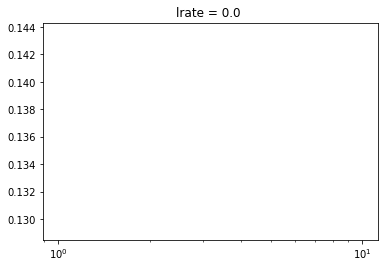

I value is 0.1


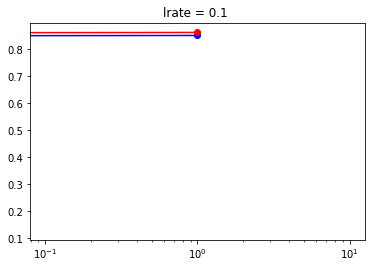

I value is 0.2


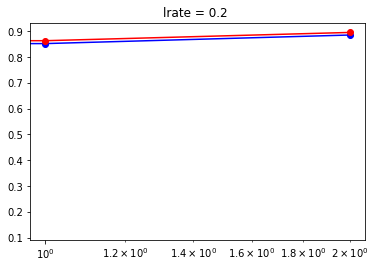

I value is 0.30000000000000004


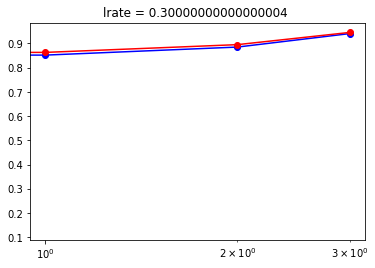

I value is 0.4


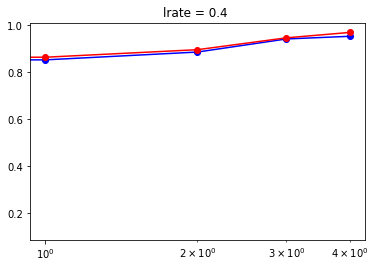

I value is 0.5


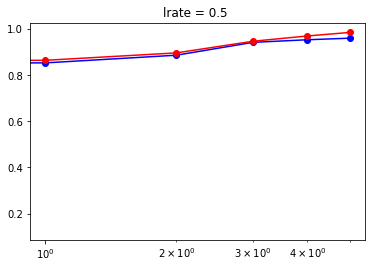

I value is 0.6000000000000001


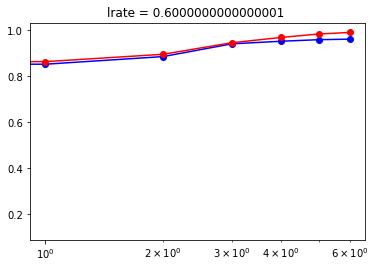

I value is 0.7000000000000001


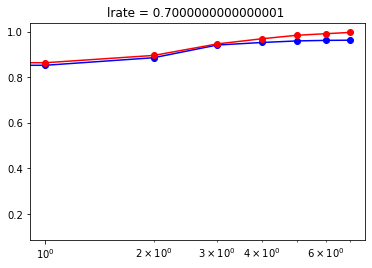

I value is 0.8


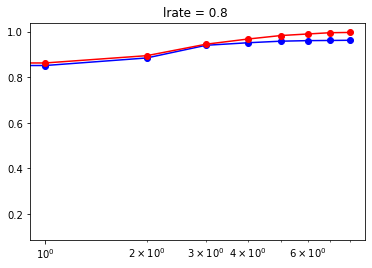

I value is 0.9


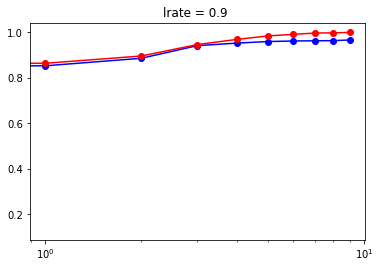

I value is 1.0


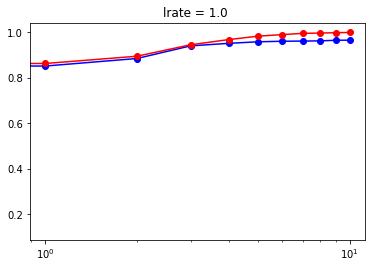

In [7]:
lrate = [10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 0.1, 1]
lrate2 = np.linspace(0,.3,31)
lrate3 = np.linspace(0,1,11)
net = tmpNet
for i in range(len(lrate3)) :
    train_net(net,lrate3[i])
    net = tmpNet
plt.show()

In [8]:
train_loader, validation_loader, test_loader = data_loader()
print(calc_acc(test_loader,net))

0.9524
